# [WSI] Ćwiczenie nr 2
### Algorytmy ewolucyjne

Mikołaj Wewiór 318407


In [92]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy


RAST_BOUNDS = [-5.12, 5.12]
GRIE_BOUNDS = [-50, 50]
DROP_BOUNDS = [-4, 4]
DIMENSIONS = 2


PLOT_STEPS = 200
PLOT_COLOR = "turbo"
PARTICLES_COLOR = 'white'
BEST_COLOR = "magenta"
# viridis # plasma # inferno # magma # cividis
# cubehelix # gist_earth # turbo # terrain


ITERATIONS = 200
POPULATION = 25
PC = 0.6
PM = 0.4
SIGMA = 0.5
ELITE_SUCCESSION = 1



In [93]:
class Function:

    def __init__(self, bounds, dimensions, global_optimum=0.0):
        self._name = None
        self._bounds = bounds
        self._dimensions = dimensions
        self._global_optimum = global_optimum


    def name(self) -> str:
        return self._name

    def dimension(self) -> int:
        return self._dimensions

    def bounds(self) -> list:
        return self._bounds

    def bound(self) -> float:
        return max(self.bounds())

    def global_optimum(self) -> float:
        return self._global_optimum

    def get_bounds(self) -> tuple:
        return self.bounds()[0], self.bounds()[1]

    def q(self) -> float:
        pass


In [94]:
class Rastrigin(Function):

    def __init__(self, bounds, dimensions):
        super().__init__(bounds, dimensions)
        self._name = "Rastrigin"

    def q(self, x_vector) -> float:
        d = self.dimension()
        partial_cost = lambda x: x**2 - 10*np.cos(2*np.pi*x)

        cost = 10*d
        for i in range(d) : cost += partial_cost(x_vector[i])

        return cost


In [95]:
class Griewank(Function):

    def __init__(self, bounds, dimensions):
        super().__init__(bounds, dimensions)
        self._name = "Griewank"

    def q(self, x_vector) -> float:
        d = self.dimension()

        SUM = 0
        for i in range(d):
            SUM += x_vector[i]**2
        SUM = SUM / 4000

        PI = 1
        for i in range(d):
            PI = PI*np.cos(
                x_vector[i]*np.sqrt(i+1)/(i+1)
            )

        return SUM - PI + 1


In [96]:
class DropWave(Function):
    def __init__(self, bounds, dimensions, global_optimum=0.0):
        super().__init__(bounds, dimensions, global_optimum)
        self._name = "DropWave"

    def q(self, x_vector) -> float:
        d = self.dimension()

        square = 0
        for i in range(d):
            square += x_vector[i]**2

        numerator = 1 + np.cos(12*np.sqrt(square))
        denominator = 0.5 * square + 2

        return 1-numerator/denominator


In [97]:
class Quadratic(Function):

    def __init__(self, bounds, dimensions, global_optimum=0.0):
        super().__init__(bounds, dimensions, global_optimum)
        self._name = "Quadratic"


    def q(self, x_vector) -> float:
        d = self._dimensions

        cost = 0
        for i in range(d):
            cost += (x_vector[i])**2

        return cost

In [98]:
class Particle:
    def __init__(self, id: int, position: list, function: Function):
        self._id = id
        self._position = position
        self._function = function
        self._rank = None
        self.q = None

    def function(self) -> Function:
        return self._function

    def id(self) -> int:
        return self._id

    def position(self) -> list:
        return self._position

    def value(self) -> float:
        return self.q

    def rank(self) -> float:
        return self._rank

    def set_position(self, index, value):
        self._position[index] = value

    def set_positions(self, values):
        if len(values) == self.function().dimension():
            self._position = values

    def set_value(self):
        x = self.position()
        self.q = self.function().q(x)

    def set_rank(self, rank):
        self._rank = rank

    def fix_position(self):
        min_bound, max_bound = self.function().get_bounds()
        """Metoda naprawy rozwiązania przez zawijanie"""
        for d in range(self.function().dimension()):
            while self.position()[d] > max_bound:
                difference = self.position()[d] - max_bound
                self.set_position(d, min_bound + difference)
            while self.position()[d] < min_bound:
                difference = self.position()[d] - min_bound
                self.set_position(d, max_bound + difference)


    def print(self):
        print(f'{self.id()} | {self.position()} | {self.value()} | {self.function().name()}')

In [99]:
class Evolution:
    def __init__(self, function: Function, iterations: int, population_count: int, mutation_factor: float, crossing_factor: float, mutation_sigma: float = None, elite_succession : int = 1):

        def generate_population() -> list:
            bound = function.bound()
            population = []
            for id in range(population_count):
                x1 = np.random.uniform(-bound, bound)
                x2 = np.random.uniform(-bound, bound)
                particle = Particle(id+1, [x1, x2], function)
                particle.set_value()
                population.append(particle)
            return population

        self._function = function
        self._iterations = iterations
        self._population_count = population_count
        self._population = generate_population()
        self._mutation_factor = mutation_factor
        self._mutation_sigma = mutation_sigma
        self._crossing_factor = crossing_factor
        self._elite_successors = elite_succession
        self._current_best_fitness = None
        self._history_best_fitness = None


    def function(self) -> Function:
        return self._function

    def iterations(self) -> int:
        return self._iterations

    def pm(self) -> float:
        return self._mutation_factor

    def pc(self) -> float:
        return self._crossing_factor

    def sigma(self) -> float:
        return self._mutation_sigma

    def elites_count(self) -> int:
        return self._elite_successors

    def population(self) -> list:
        return self._population

    def nominal_population_count(self) -> int:
        return self._population_count

    def current_population_count(self) -> int:
        return len(self.population())

    def set_new_population(self, population):
        self._population = population

    def sort_population(self):
        self.population().sort(key = lambda p: p.value())
        self._current_best_fitness = self.population()[0]

    def best_fitness(self) -> Particle:
        return self._current_best_fitness

    def best_history_fitness(self) -> Particle:
        history_best = self._history_best_fitness
        if history_best is None:
            return self.best_fitness()
        return history_best

    def set_best_fitness(self, best_fitness):
        self._current_best_fitness = best_fitness
        if self._history_best_fitness is None:
            self._history_best_fitness = best_fitness
        elif best_fitness.value() < self._history_best_fitness.value():
            self._history_best_fitness = best_fitness


    def fitness_func(self):
        for particle in self.population():
            particle.set_value()
        self.sort_population()

        best_fitness = self.best_history_fitness()
        best_fitness.set_rank(0)
        best_position = best_fitness.position()

        # best_value = best_fitness.value()
        # for particle in self.population()[1::]:
        #     r = (particle.value() - best_value) ** 2
        #     particle.set_rank(r)

        for particle in self.population()[1::]:
            dist = 0
            for d in range(len(best_position)):
                dist += (particle.position()[d] - best_position[d])**2
            r = np.sqrt(dist)
            particle.set_rank(r)

        """Gdyby znane było globalne optimum w punkcie (0, 0):"""
        # for particle in self.population():
        #     r = 0
        #     for d in range(self.function.dimention()):
        #         r += particle.position()[d]**2
        #     particle.set_rank(np.sqrt(r))




    def crossover(self, first_parent: Particle) -> Particle:
        a = np.random.random()
        if a < self.pc():

            second_parent = random.choice(self.population())
            possible_position = []

            for parent in [first_parent, second_parent]:
                for d in range(self.function().dimension()):
                    possible_position.append(parent.position()[d])

            particle = Particle(first_parent.id(), [None, None], self.function())

            for d in range(self.function().dimension()):
                particle.set_position(d, random.choice(possible_position))

        else:
            particle = first_parent

        particle.fix_position()
        return particle


    def mutation(self, particle: Particle) -> Particle:
        a = np.random.random()
        if a < self.pm():
            for i in range(self.function().dimension()):
                mut = self.sigma() * np.random.randn()
                particle.position()[i] += mut
            particle.fix_position()
        return particle


    def reproduction(self):
        reproduction = []
        while( len(reproduction) < self.nominal_population_count() - self.elites_count()):
            particle1 = random.choice(self.population())
            particle2 = random.choice(self.population())

            if particle1.rank() <= particle2.rank():
                reproduction.append(copy.deepcopy(particle1))
            else:
                reproduction.append(copy.deepcopy(particle2))

        self.set_new_population(reproduction)


    def succession(self, new_population: list):
        for index in range(self.elites_count()):
            new_population.insert(index, self.best_fitness())
        self.set_new_population(new_population)


    def new_generation(self):
        self.fitness_func()
        self.reproduction()
        successing_population = []

        for particle in self.population():
            crossed_particle = self.crossover(particle)
            mutated_particle = self.mutation(crossed_particle)
            successing_population.append(mutated_particle)

        self.succession(successing_population)



In [100]:
class Plotter:
    def __init__(self, function: Function, steps: int, bounds: list = None):
        self._function = function
        self._steps = steps
        self._dimensions = function.dimension()
        self._bounds = bounds
        self._axes = None


    def funciton(self):
        return self._function

    def name(self):
        return self.funciton().name()

    def d(self):
        return self._dimensions

    def steps(self):
        return self._steps

    def bounds(self):
        if self._bounds != None:
            return self._bounds
        return self.funciton().bounds()

    def q(self, x_vector):
        return self.funciton().q(x_vector)

    def plot(self, drow_now = False):

        step = self.steps()
        bounds = self.bounds()
        diff = bounds[1] - bounds[0]

        Z = np.zeros((step+1, step+1))
        for i in range(step+1):
            y = bounds[0] + i*diff/step
            for j in range(step+1):
                x = bounds[0] + j*diff/step
                Z[i][j] = self.q([x, y])

        x = np.linspace(bounds[0], bounds[1], step+1)
        y = np.linspace(bounds[0], bounds[1], step+1)

        X, Y = np.meshgrid(x, y)

        plt.figure()
        plt.ion()

        contour = plt.contourf(X, Y, Z, cmap=PLOT_COLOR, levels=100)
        cbar = plt.colorbar(contour)
        cbar.set_label("Wartość funkcji")

        plt.grid(True)
        plt.xlabel("x1")
        plt.ylabel("x2", rotation=0)

        if not drow_now:
            plt.show()


    def draw_points(self, evolution: Evolution, fig= None):
        # plt.ion()
        # self.plot(drow_online=True)

        X = []
        Y = []
        best_fitnesses = evolution.best_fitness().position()
        for particle in evolution.population():
            X.append(particle.position()[0])
            Y.append(particle.position()[1])

        plt.scatter(X, Y, c=PARTICLES_COLOR, marker=".")
        plt.scatter(best_fitnesses[0], best_fitnesses[1], c=BEST_COLOR, marker="*")
        plt.show()


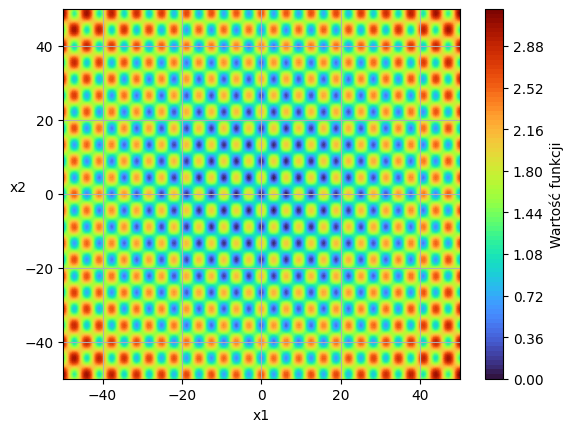

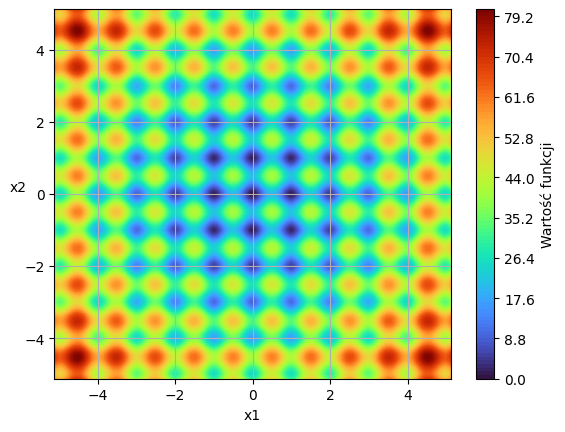

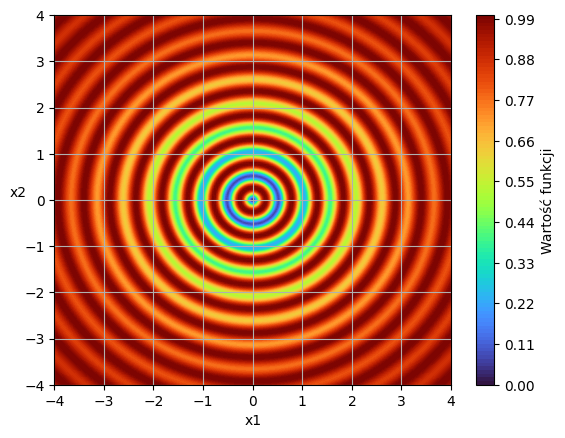

In [101]:
f1 = Plotter(Griewank(GRIE_BOUNDS, DIMENSIONS), PLOT_STEPS)
f2 = Plotter(Rastrigin(RAST_BOUNDS, DIMENSIONS), PLOT_STEPS)
f3 = Plotter(DropWave(DROP_BOUNDS, DIMENSIONS), PLOT_STEPS)

f1.plot()
f2.plot()
f3.plot()


</br>
</br>

# TESTY

Od kacpra wziąć funkcję która zapisuje do Latexa </br>
Zrobić jakieś średnie dla kilku wyników i dopiero te testy</br>
</br></br>

# Wykres błędu (MSE) od liczebności populacji </br>
można pomyśleć nad zrobieniem np 5 tesdtów i uśrednić wyniki

In [102]:
testing_functions = [
    # DropWave(DROP_BOUNDS, DIMENSIONS),
    Griewank(GRIE_BOUNDS, DIMENSIONS),
    Rastrigin(RAST_BOUNDS, DIMENSIONS)
]

testfun = Rastrigin(RAST_BOUNDS, DIMENSIONS)


default_populations = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50, 80, 100, 120, 150, 200]
populacje= []
mse_p = []

for _ in range(5):
    cur_pop = []
    cur_mse = []
    for pop_count in default_populations:
        plot = Plotter(testfun, PLOT_STEPS)
        sigma = SIGMA
        if testfun.name() == "Griewank": sigma = 2
        # population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
        population = Evolution(testfun, ITERATIONS, pop_count, PM, PC, sigma)
        best_fitnesses = []

        t = 0
        while t < population.iterations():
            t+=1
            population.new_generation()
            best_fitnesses.append(population.best_fitness().value())
        cur_pop.append(pop_count)
        cur_mse.append(population.best_fitness().value())
    populacje.append(cur_pop)
    mse_p.append(cur_mse)



In [103]:
mean_results_val_p = []
for i in range(len(default_populations)):
    sum = 0
    for t in range(5):
        sum += mse_p[t][i]
    mean_results_val_p.append(sum/5)
results_pop = cur_pop
results_p = [default_populations, mean_results_val_p]


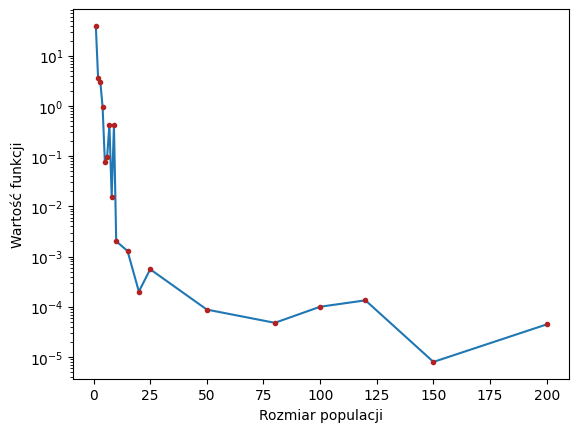

In [104]:

plt.plot(default_populations, mean_results_val_p)
plt.plot(default_populations, mean_results_val_p, '.', c='firebrick')
plt.yscale('log')
plt.xlabel('Rozmiar populacji')
plt.ylabel('Wartość funkcji')
plt.show()
# plt.plot(cur_pop[1:10], mean_results_val_p[1:10])
# plt.yscale('log')
# plt.show()
# plt.plot(cur_pop[10::], mean_results_val_p[10::])
# plt.yscale('log')
# plt.show()
# plt.plot(cur_pop[-4::], mean_results_val_p[-4::])
# plt.show()

# Wykres błędu (MSE) od liczby iteracji </br>
można pomyśleć nad zrobieniem np 5 tesdtów i uśrednić wyniki

In [105]:
testing_functions = [
    # DropWave(DROP_BOUNDS, DIMENSIONS),
    Griewank(GRIE_BOUNDS, DIMENSIONS),
    Rastrigin(RAST_BOUNDS, DIMENSIONS)
]

testfun = Rastrigin(RAST_BOUNDS, DIMENSIONS)


default_iterations = [5, 10, 25, 50, 80, 100, 150, 250, 500, 800, 1000, 2500, 5000, 8000, 10000]
iteracje = []
mse_i = []

for _ in range(5):
    cur_iter = []
    cur_mse = []

    for iters in default_iterations:
        # for testfun in testing_functions:
        plot = Plotter(testfun, PLOT_STEPS)
        sigma = SIGMA
        if testfun.name() == "Griewank": sigma = 2
        # population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
        population = Evolution(testfun, iters, POPULATION, PM, PC, sigma)
        best_fitnesses = []

        t = 0
        while t < population.iterations():
            t+=1
            population.new_generation()
            best_fitnesses.append(population.best_fitness().value())
        # iteracje.append(iters)
        # mse_i.append(population.best_fitness().value()**2)
        cur_iter.append(iters)
        cur_mse.append(population.best_fitness().value())
    iteracje.append(cur_pop)
    mse_i.append(cur_mse)



In [106]:
mean_results_val_i = []
for i in range(len(default_iterations)):
    sum = 0
    for t in range(5):
        sum += mse_i[t][i]
    mean_results_val_i.append(sum/5)
results_iter = cur_iter
results_i = [default_iterations, mean_results_val_i]

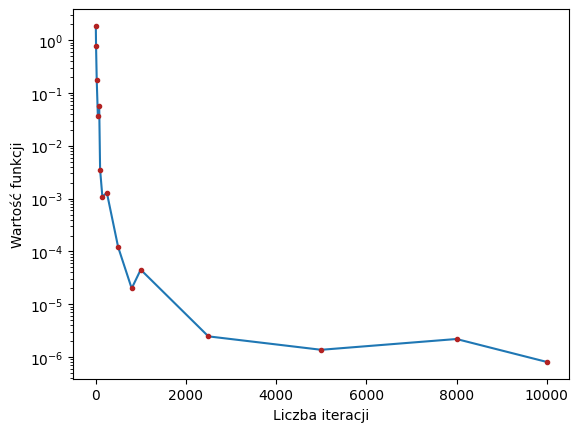

In [107]:

plt.plot(default_iterations, mean_results_val_i)
plt.plot(default_iterations, mean_results_val_i, '.', c='firebrick')
plt.yscale('log')
plt.xlabel('Liczba iteracji')
plt.ylabel('Wartość funkcji')
plt.show()
# plt.plot(default_iterations[1:8], mean_results_val_i[1:8])
# plt.yscale('log')
# plt.show()
# plt.plot(default_iterations[9::], mean_results_val_i[9::])
# plt.yscale('log')
# plt.show()
# plt.plot(default_iterations[-4::], mean_results_val_i[-4::])
# plt.show()
# plt.plot(default_iterations[6:11], mean_results_val_i[6:11])
# plt.show()

# Wykres błędu (MSE) od p-stwa mutacji </br>
można pomyśleć nad zrobieniem np 5 tesdtów i uśrednić wyniki


In [108]:
testing_functions = [
    # DropWave(DROP_BOUNDS, DIMENSIONS),
    Griewank(GRIE_BOUNDS, DIMENSIONS),
    Rastrigin(RAST_BOUNDS, DIMENSIONS)
]

testfun = Rastrigin(RAST_BOUNDS, DIMENSIONS)


default_mutations = []
for i in range(101):
    default_mutations.append(i/100)
mutacje = []
mse_m = []

for _ in range(5):
    cur_mut = []
    cur_mse = []
    for mutacja in default_mutations:
        # for testfun in testing_functions:
        plot = Plotter(testfun, PLOT_STEPS)
        sigma = SIGMA
        if testfun.name() == "Griewank": sigma = 2
        # population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
        population = Evolution(testfun, ITERATIONS, POPULATION, mutacja, PC, sigma)
        best_fitnesses = []

        t = 0
        while t < population.iterations():
            t+=1
            population.new_generation()
            best_fitnesses.append(population.best_fitness().value())
        cur_mut.append(mutacja)
        cur_mse.append(population.best_fitness().value())
    mutacje.append(cur_mut)
    mse_m.append(cur_mse)


In [109]:
mean_results_val_m = []
for i in range(len(default_mutations)):
    sum = 0
    for t in range(5):
        sum += mse_m[t][i]
    mean_results_val_m.append(sum/5)
results_m = [default_mutations, mean_results_val_m]

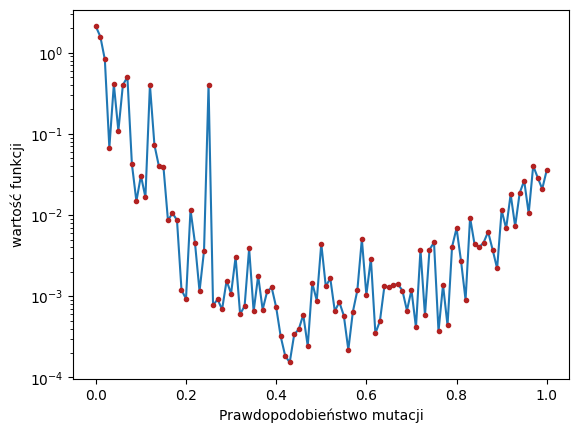

In [110]:

plt.plot(default_mutations, mean_results_val_m)
plt.plot(default_mutations, mean_results_val_m, '.', c='firebrick')
plt.yscale('log')
plt.xlabel('Prawdopodobieństwo mutacji')
plt.ylabel('wartość funkcji')
plt.show()
# plt.plot(mutacje[3::], mean_results_val_m[3::])
# plt.show()
# plt.plot(mutacje[20:80], mean_results_val_m[20:80])
# plt.show()

# Wykres błędu (MSE) od p-stwa krzyżowania </br>
można pomyśleć nad zrobieniem np 5 tesdtów i uśrednić wyniki


In [111]:
testing_functions = [
    # DropWave(DROP_BOUNDS, DIMENSIONS),
    Griewank(GRIE_BOUNDS, DIMENSIONS),
    Rastrigin(RAST_BOUNDS, DIMENSIONS)
]

testfun = Rastrigin(RAST_BOUNDS, DIMENSIONS)


default_cross_prctg = []
for i in range(101):
    default_cross_prctg.append(i/100)
krzyzowania = []
mse_c = []

for _ in range(5):
    cur_cro = []
    cur_mse = []
    for cross in default_cross_prctg:
        # for testfun in testing_functions:
        plot = Plotter(testfun, PLOT_STEPS)
        sigma = SIGMA
        if testfun.name() == "Griewank": sigma = 2
        # population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
        population = Evolution(testfun, ITERATIONS, POPULATION, PM, cross, sigma)
        best_fitnesses = []

        t = 0
        while t < population.iterations():
            t+=1
            population.new_generation()
            best_fitnesses.append(population.best_fitness().value())
        # krzyzowania.append(krzyz)
        # mse_g.append(population.best_fitness().value()**2)
        cur_cro.append(cross)
        cur_mse.append(population.best_fitness().value())
    krzyzowania.append(cur_mut)
    mse_c.append(cur_mse)


In [112]:
mean_results_val_c = []
for i in range(len(default_cross_prctg)):
    sum = 0
    for t in range(5):
        sum += mse_c[t][i]
    mean_results_val_c.append(sum/5)
results_c = [default_cross_prctg, mean_results_val_c]

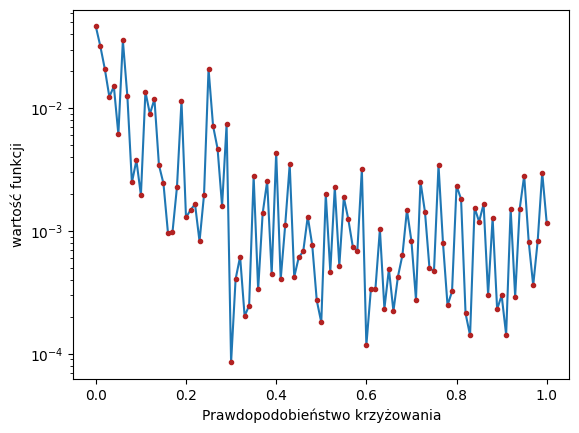

In [113]:

plt.plot(default_cross_prctg, mean_results_val_c)
plt.plot(default_cross_prctg, mean_results_val_c, '.', c='firebrick')
plt.yscale('log')
plt.xlabel('Prawdopodobieństwo krzyżowania')
plt.ylabel('wartość funkcji')
plt.show()
# plt.plot(krzyzowania[3::], mse_g[3::])
# plt.show()
# plt.plot(krzyzowania[20:80], mse_g[20:80])
# plt.show()

Testy dla różnych wartości prawdopodobieństwa mutacji


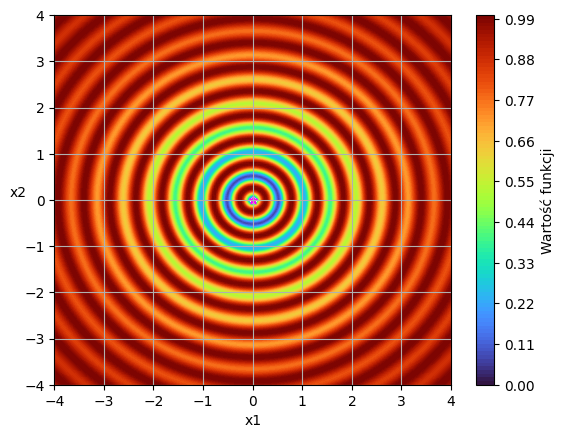

0.0018737765282338392


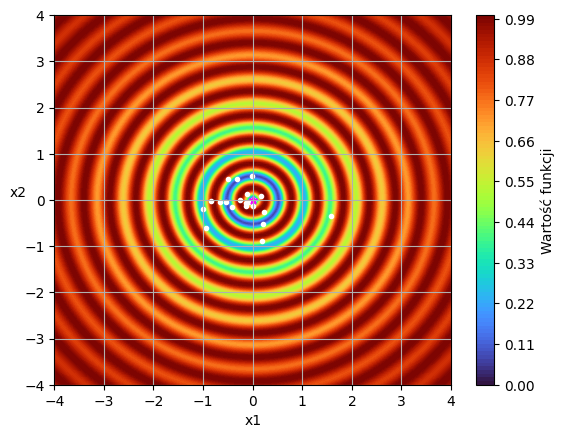

0.00022293263122030726


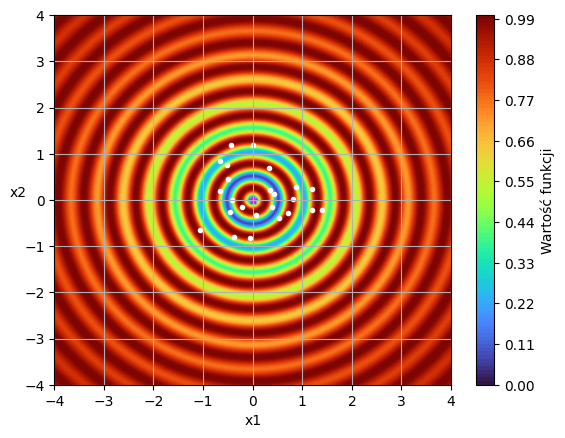

9.540766419491309e-05


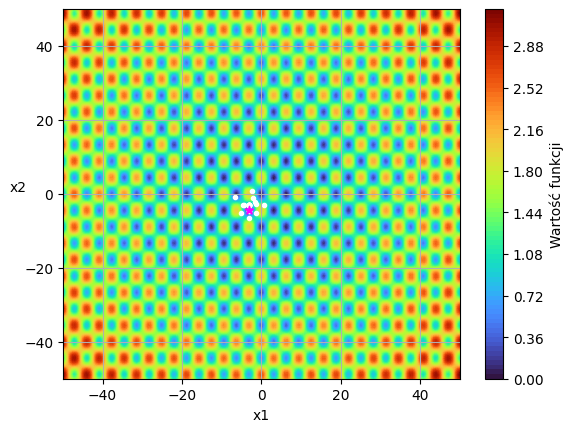

0.007565429218830522


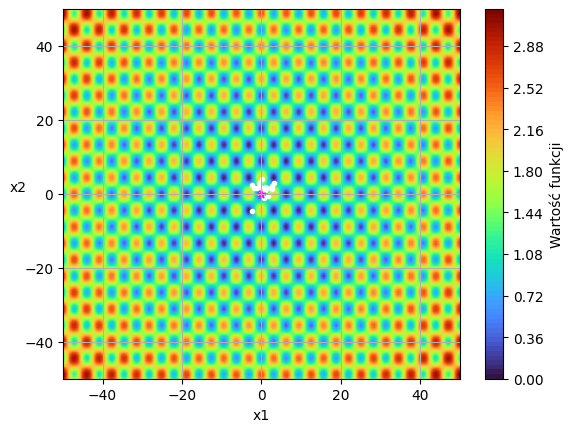

6.212986625286909e-06


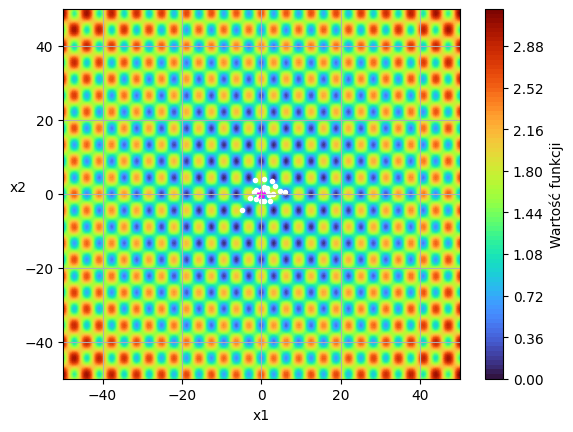

0.000878742813955613


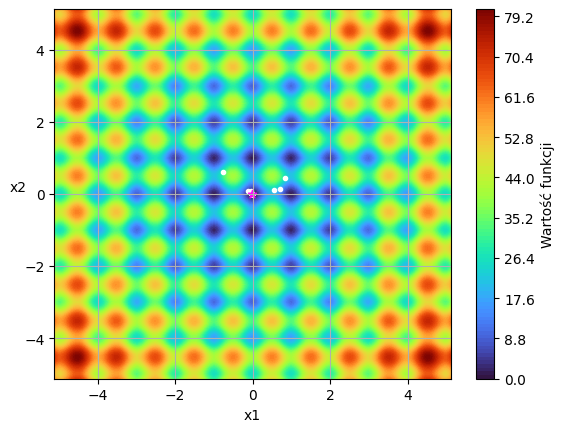

0.012482431963871221


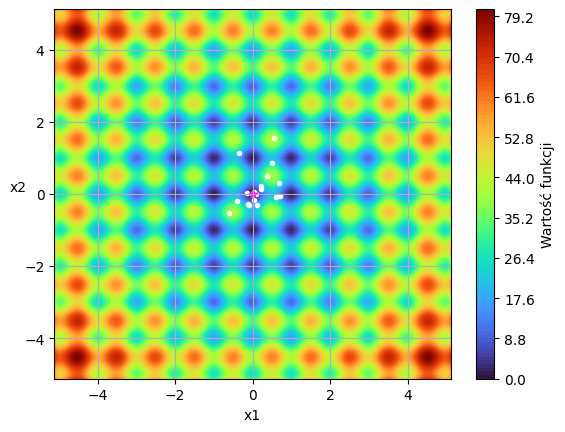

0.0004098187620051874


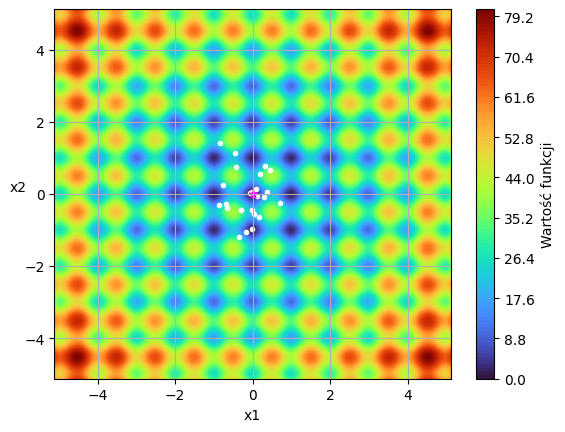

3.3786090533283186e-05


In [116]:

testing_functions = [
    DropWave(DROP_BOUNDS, DIMENSIONS),
    Griewank(GRIE_BOUNDS, DIMENSIONS),
    Rastrigin(RAST_BOUNDS, DIMENSIONS)
]

pms = [0.1, 0.5, 0.9]
pcs = [0.1, 0.5, 0.9]

print("Testy dla różnych wartości prawdopodobieństwa mutacji")
for testfun in testing_functions:
    for mutacja in pms:
        plot = Plotter(testfun, PLOT_STEPS)
        sigma = SIGMA
        if testfun.name() == "Griewank": sigma = 2

        # population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
        population = Evolution(testfun, ITERATIONS, POPULATION, mutacja, PC, sigma)
        best_fitnesses = []

        t = 0
        while t < population.iterations():
            t+=1
            population.new_generation()
            best_fitnesses.append(population.best_fitness().value())

        plot.plot(drow_now=True)
        plot.draw_points(population)
        print(population.best_fitness().value())

# print("\n\n\n")
# print("Testy dla różnych wartości prawdopodobieństwa krzyzowania")
# for testfun in testing_functions:
#     for krzyz in pcs:
#         plot = Plotter(testfun, PLOT_STEPS)
#         sigma = SIGMA
#         if testfun.name() == "Griewank": sigma = 2

#         # population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
#         population = Evolution(testfun, ITERATIONS, POPULATION, PM, krzyz, sigma)
#         best_fitnesses = []

#         t = 0
#         while t < population.iterations():
#             t+=1
#             population.new_generation()
#             best_fitnesses.append(population.best_fitness().value())

#         plot.plot(drow_now=True)
#         plot.draw_points(population)
#         print(population.best_fitness().value())



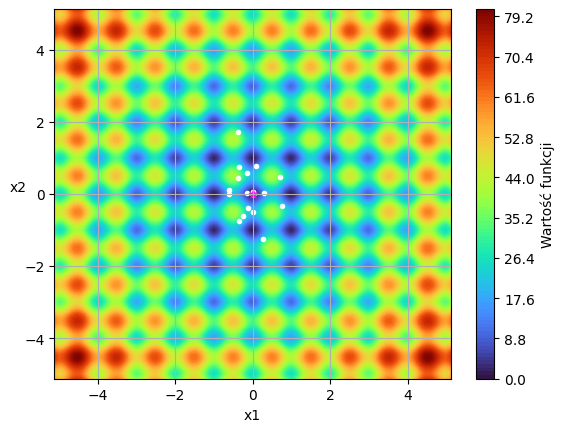

1.4604976463772346e-06


In [115]:
plot = Plotter(testfun, PLOT_STEPS)
sigma = SIGMA
if testfun.name() == "Griewank": sigma = 2

# population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
population = Evolution(testfun, ITERATIONS, POPULATION, PM, PC, sigma)
best_fitnesses = []

t = 0
while t < population.iterations():
    t+=1
    population.new_generation()
    best_fitnesses.append(population.best_fitness().value())

plot.plot(drow_now=True)
plot.draw_points(population)
print(population.best_fitness().value())

1) Wykres zależności wartości funkcji dopasowania od: </br>
    -> liczby iteracji</br>
    -> rozmiaru populacji</br>
    -> p-stwa mutacji</br>
    -> p-stwa krzyżowania</br>
</br>

2) Wyników dla powyższych zależności </br>

3) podsumowanie wyników </br>

4) Wizualizacje populacji końcowej dla różnych parametrów

